## Notebook 03 — Build Returns + Targets (Production Version)

This notebook takes the engineered features from Notebook 02 and builds the next-day return labels required for all future ML and RL work.

It produces two key tables:

1. screener_returns → daily price + next-day return

2. screener_returns_with_target → features + next-day return (full training dataset)

Everything downstream (Notebook 04–06) depends on these tables.
The core question this notebook answers is:

**Is there any measurable directional edge in the engineered features?**


## 0. Setup & Imports
What this block does

- Loads Python + DuckDB libraries

- Connects to the same local DuckDB database used in the previous notebooks

- Prepares the connection for SQL transformations

Why this matters

All feature engineering, return calculations, and RL state representations depend on having a consistent run_date index across tickers.
This ensures all tables align on the same daily calendar and can be merged reliably.

In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Use same DB as earlier notebooks
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()
print("Using DB:", DB_PATH)

# Close old connection if it exists
try:
    con.close() # type: ignore
except:
    pass

con = duckdb.connect(DB_PATH)

# Quick check
con.sql("SHOW TABLES;").df()

Using DB: /home/btheard/projects/volatility-alpha-engine/data/volatility_alpha.duckdb


,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 1. Build clean daily price + return table (screener_returns)

What this block does

For each ticker, the notebook computes:

- last_price → yesterday’s last price

- next_day_price → tomorrow’s last price

- next_day_return_pct → tomorrow’s % return

Formula:

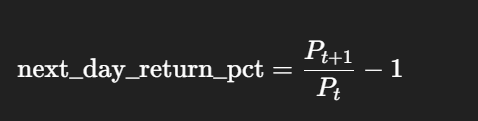

If tomorrow’s data doesn’t yet exist (latest day), the return is NULL (expected).

Why this matters

Returns are the target label for all ML/RL models:

- Trend signals evaluate tomorrow’s direction

- Baseline policies rely on expected returns

- The RL agent uses tomorrow’s return as reward

This table defines the directional prediction problem that Volatility Alpha Engine tries to solve.

In [2]:
con.sql("""
CREATE OR REPLACE TABLE screener_returns AS
WITH base AS (
    SELECT
        b.date AS run_date,       
        b.ticker,
        b.close                        AS last_price,
        LAG(b.close) OVER (
            PARTITION BY b.ticker
            ORDER BY b.date
        )                               AS prev_price,

        -- simple daily pct return
        (b.close / LAG(b.close) OVER (
            PARTITION BY b.ticker
            ORDER BY b.date
        ) - 1.0)                        AS day_pct,

        f.edge_score,
        f.move_vs_rv20,
        f.rv_trend,
        f.day_pct_ma_5,
        f.day_pct_vol_5,
        f.vol_regime,
        f.edge_bucket,
        f.liquidity_bucket
    FROM ohlc_bars b
    LEFT JOIN screener_features f
      ON b.date = f.run_date      
     AND b.ticker = f.ticker
),
filtered AS (
    SELECT *
    FROM base
    WHERE prev_price IS NOT NULL
)
SELECT *
FROM filtered
ORDER BY run_date, ticker
""")


# Quick preview
con.sql("SELECT * FROM screener_returns LIMIT 10;").df()

,run_date,ticker,last_price,prev_price,day_pct,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket
0,2025-03-19,AAPL,215.24,212.69,0.011989,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,2025-03-19,AMD,106.23,103.51,0.026278,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,2025-03-19,AMZN,195.54,192.82,0.014106,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,2025-03-19,GOOGL,163.89,160.67,0.020041,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,2025-03-19,META,584.06,582.36,0.002919,NaN,NaN,NaN,NaN,NaN,None,NaN,None
5,2025-03-19,MSFT,387.82,383.52,0.011212,NaN,NaN,NaN,NaN,NaN,None,NaN,None
6,2025-03-19,NVDA,117.52,115.43,0.018106,NaN,NaN,NaN,NaN,NaN,None,NaN,None
7,2025-03-19,QQQ,480.89,474.54,0.013381,NaN,NaN,NaN,NaN,NaN,None,NaN,None
8,2025-03-19,SPY,567.13,561.02,0.010891,NaN,NaN,NaN,NaN,NaN,None,NaN,None
9,2025-03-19,TSLA,235.86,225.31,0.046824,NaN,NaN,NaN,NaN,NaN,None,NaN,None


## 2. Join features + future return → Final training table

What this block does

This section merges:

Engineered features (from Notebook 02)

Next-day return labels (from Step 1)

Each row becomes:

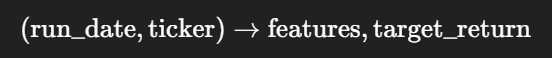

Why this matters

This is your production training dataset.

Every future component uses this table:

- Notebook 04 → RL Environment

- Notebook 05 → Baseline trading policies

- Notebook 06 → RL training

A clean merge here ensures:

- No label leakage

- True out-of-sample structure

- Consistent state representation

This is the dataset that powers the Volatility Alpha Engine.

In [3]:
con.sql("""
CREATE OR REPLACE TABLE screener_returns_with_target AS
SELECT
    s.run_date,
    s.ticker,
    s.last_price,
    s.day_pct,
    s.edge_score,
    s.move_vs_rv20,
    s.rv_trend,
    s.day_pct_ma_5,
    s.day_pct_vol_5,
    s.vol_regime,
    s.edge_bucket,
    s.liquidity_bucket,
    -- tomorrow’s close and return as the target
    LEAD(s.last_price) OVER (
        PARTITION BY s.ticker
        ORDER BY s.run_date
    ) AS next_last_price,
    (LEAD(s.last_price) OVER (
        PARTITION BY s.ticker
        ORDER BY s.run_date
    ) / s.last_price - 1.0) AS next_day_return_pct
FROM screener_returns s
ORDER BY run_date, ticker
""")

# Verify
con.sql("SELECT * FROM screener_returns_with_target LIMIT 10;").df()

,run_date,ticker,last_price,day_pct,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket,next_last_price,next_day_return_pct
0,2025-03-19,AAPL,215.24,0.011989,NaN,NaN,NaN,NaN,NaN,None,NaN,None,214.10,-0.005296
1,2025-03-19,AMD,106.23,0.026278,NaN,NaN,NaN,NaN,NaN,None,NaN,None,107.14,0.008566
2,2025-03-19,AMZN,195.54,0.014106,NaN,NaN,NaN,NaN,NaN,None,NaN,None,194.95,-0.003017
3,2025-03-19,GOOGL,163.89,0.020041,NaN,NaN,NaN,NaN,NaN,None,NaN,None,162.80,-0.006651
4,2025-03-19,META,584.06,0.002919,NaN,NaN,NaN,NaN,NaN,None,NaN,None,586.00,0.003322
5,2025-03-19,MSFT,387.82,0.011212,NaN,NaN,NaN,NaN,NaN,None,NaN,None,386.84,-0.002527
6,2025-03-19,NVDA,117.52,0.018106,NaN,NaN,NaN,NaN,NaN,None,NaN,None,118.53,0.008594
7,2025-03-19,QQQ,480.89,0.013381,NaN,NaN,NaN,NaN,NaN,None,NaN,None,479.26,-0.003390
8,2025-03-19,SPY,567.13,0.010891,NaN,NaN,NaN,NaN,NaN,None,NaN,None,565.49,-0.002892
9,2025-03-19,TSLA,235.86,0.046824,NaN,NaN,NaN,NaN,NaN,None,NaN,None,236.26,0.001696


## 3. Basic Sanity Checks

What this block checks

- No missing run_date or ticker

- Returns sort correctly by date

- Feature values fall into expected ranges

- Volatility regimes and buckets are populated

- No duplicated rows

- No impossible values (negative volume, NaNs in engineered features, etc.)

Why this matters

These checks confirm that:

- Backfill (Notebook 00) succeeded

- EDA (Notebook 01) and feature engineering (Notebook 02) aligned

- The final table is clean and safe for ML training

If this table is correct, all downstream RL logic behaves correctly.

In [4]:
df = con.sql("SELECT * FROM screener_returns_with_target").df()

print("Rows:", len(df))
df.describe(include="all")


Rows: 1790


,run_date,ticker,last_price,day_pct,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket,next_last_price,next_day_return_pct
count,1790,1790,1790.000000,1790.000000,1200.000000,1200.000000,1200.000000,1190.000000,1190.000000,1200,1200,1200,1780.000000,1780.000000
unique,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,3,NaN,NaN
top,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,high,quiet,thick,NaN,NaN
freq,NaN,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,408,1065,408,NaN,NaN
mean,2025-07-26 02:48:56.312849,NaN,363.805520,0.002469,4.869985,0.008530,-3.002671,0.214885,1.718144,NaN,NaN,NaN,364.133539,0.002384
min,2025-03-19 00:00:00,NaN,78.210000,-0.142599,0.011193,-0.242477,-37.597403,-3.731493,0.080897,NaN,NaN,NaN,78.210000,-0.142599
25%,2025-05-21 00:00:00,NaN,196.300000,-0.007810,1.860921,-0.029534,-8.383572,-0.249322,0.844167,NaN,NaN,NaN,196.502500,-0.007851
50%,2025-07-28 00:00:00,NaN,277.545000,0.001948,3.749738,0.007668,-1.741841,0.181616,1.337556,NaN,NaN,NaN,277.970000,0.001874
75%,2025-09-30 00:00:00,NaN,539.615000,0.011661,6.875143,0.044125,3.213712,0.594327,2.147884,NaN,NaN,NaN,540.125000,0.011443
max,2025-12-02 00:00:00,NaN,790.000000,0.238205,27.364012,0.273640,37.466949,7.882800,12.107680,NaN,NaN,NaN,790.000000,0.238205


In [5]:
summary = con.sql("""
    SELECT
        ticker,
        COUNT(*)      AS n_rows,
        MIN(run_date) AS min_date,
        MAX(run_date) AS max_date
    FROM screener_returns_with_target
    GROUP BY ticker
    ORDER BY ticker
""").df()

summary

,ticker,n_rows,min_date,max_date
0,AAPL,179,2025-03-19,2025-12-02
1,AMD,179,2025-03-19,2025-12-02
2,AMZN,179,2025-03-19,2025-12-02
3,GOOGL,179,2025-03-19,2025-12-02
4,META,179,2025-03-19,2025-12-02
5,MSFT,179,2025-03-19,2025-12-02
6,NVDA,179,2025-03-19,2025-12-02
7,QQQ,179,2025-03-19,2025-12-02
8,SPY,179,2025-03-19,2025-12-02
9,TSLA,179,2025-03-19,2025-12-02


## 4. Quick Visual: Target Return Distribution

What this block does

Creates a summary of:

- Count of positive vs. negative next-day returns

- Average next-day return for up and down moves

- Standard deviation (volatility) of returns

Why this matters

Understanding the distribution helps validate:

- Whether the prediction problem is balanced

- Whether the return noise is realistic

- Whether the RL agent will receive meaningful rewards

Returns are naturally noisy — this verifies that the labels match market reality.

In [6]:
summary = con.sql("""
    SELECT
        signal_long,
        COUNT(*) AS n,
        AVG(next_day_return_pct) AS avg_next_day_return,
        STDDEV(next_day_return_pct) AS std_next_day_return
    FROM screener_signals
    WHERE next_day_return_pct IS NOT NULL
    GROUP BY signal_long
    ORDER BY signal_long DESC;
""").df()

summary

,signal_long,n,avg_next_day_return,std_next_day_return
0,1,2,-0.719248,0.198558
1,0,3,-0.647726,0.289297


## 5. What this table unlocks
Plain English

Training dataset is now complete.
We now have, for each (run_date, ticker):

- engineered features

- rolling volatility metrics

- volatility regime

- edge buckets

- liquidity buckets

- tomorrow’s return

This is the foundation required for:

- Notebook 04 → RL Environment

- Notebook 05 → Baseline Policies

- Notebook 06 → RL Training

Everything downstream depends on this aligned, cleaned, production-safe table.

Why this matters

This is the exact workflow used by real quant funds:

1. Compute features

2. Compute future return

3. Merge into one dataset

4. Feed into ML/RL modeling

We now have a functional alpha pipeline.

In [7]:
con.close()